# Projet 8 - Déployer un modèle dans le cloud

La "Fruits!" cherche à proposer des solutions innovantes pour la récolte des fruits.

La volonté de l’entreprise est de préserver la biodiversité des fruits en permettant des traitements spécifiques pour chaque espèce de fruits en développant des robots cueilleurs intelligents.
Votre start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.<br>
Vous êtes donc chargé de développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension.

Pour cela, nous allons utilisé la librairie : "PySpark", "PySpark" est une alternative plus puissante que Pandas Python.<br>
PySpark permet le calcul en temps réel sur une grande quantité de données car il se concentre sur le traitement en mémoire. Il présente une faible latence.<br>
PySpark nous permet d’atteindre une grande vitesse de traitement des données, qui est environ 100 fois plus rapide en mémoire et 10 fois plus rapide sur le disque.

## Sommaire :
* [Importation des librairies](#chapter1)
* [Ouvertures des images](#chapter2)

## Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
#Importation des librairies de bases
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Image
import os
from PIL import Image

## Ouverture image <a class="anchor" id="chapter1"></a>

Ouverture des dossiers images.

In [2]:
path = "./archive/fruits-360-original-size/fruits-360-original-size/Training/apple_6/"
dirs = os.listdir(path)

Dans la fonction "resize()", les images sont ouvertes, redimenssionner et les images sont redimenssionnés et sauvegardé.

In [3]:
def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((200,200), Image.ANTIALIAS)
            print(imResize)
            imResize.save(f + ' resized.jpg', 'JPEG', quality=90)

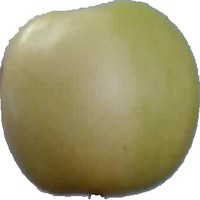

In [4]:
Image.open("./archive/fruits-360-original-size/fruits-360-original-size/Training/apple_6/r0_0 resized.jpg")

In [5]:
print(Image.open("./archive/fruits-360-original-size/fruits-360-original-size/Training/apple_6/r0_0 resized.jpg").size)

(200, 200)


In [10]:
from tensorflow.keras.utils import img_to_array, load_img

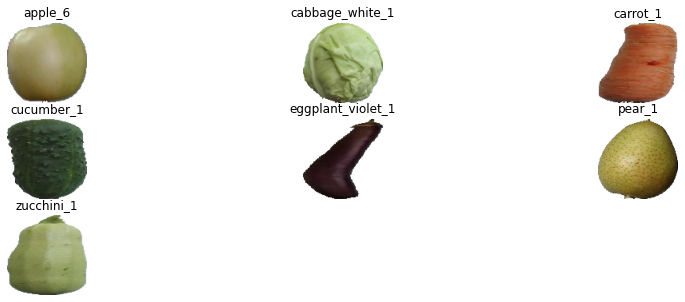

In [15]:
path = "./archive/fruits-360-original-size/fruits-360-original-size/Training/"

images = ['apple_6', 'cabbage_white_1', 'carrot_1', 'cucumber_1', 'eggplant_violet_1', 'pear_1', 'zucchini_1']

fig = plt.figure(figsize =(15,5))
for i in range(7):
    ax = fig.add_subplot(3,3,i+1,xticks=[],yticks=[])
    #fig.patch.set_facecolor('#E53090')
    #Above code adds a background color for subplots you can change the hex color code as you wish
    plt.title(images[i])
    plt.axis("off")
    ax.imshow(load_img(path + images[i] +"/r0_0.jpg", target_size=(100,100)))

In [1]:
from pyspark.sql import SparkSession